In [1]:
# -*- coding: utf-8 -*-

# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
# import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display


# set some parameters:
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100m"

a_color = "dodgerblue"

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

bassin_map = "resources/maps/survey_areas/rhone_scaled.jpeg"

# top level aggregation
top = "All survey areas"

# define the feature level and components
this_feature = {"slug":"rhone", "name":"Rhône survey area", "level":"river_bassin"}
this_level = "water_name_slug"
this_bassin = "rhone"
bassin_label = "Rhône survey area"

lakes_of_interest = ["lac-leman"]

# explanatory variables:
luse_exp = ["% buildings", "% recreation", "% agg", "% woods", "streets km", "intersects"]

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# columns needed
use_these_cols = ["loc_date" ,
                  "% to buildings",
                  "% to trans", 
                  "% to recreation",
                  "% to agg",
                  "% to woods",
                  "population",
                  this_level,
                  "streets km",
                  "intersects",
                  "length",
                  "groupname",
                  "code"
                 ]

# get your data:
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# map water_name_slug to water_name
wname_wname = dfBeaches[["water_name_slug","water_name"]].reset_index(drop=True).drop_duplicates().set_index("water_name_slug")

dfCodes.set_index("code", inplace=True)

codes_to_change = [
    ["G74", "description", "Insulation foams"],
    ["G940", "description", "Foamed EVA for crafts and sports"],
    ["G96", "description", "Sanitary-pads/tampons, applicators"],
    ["G178", "description", "Metal bottle caps and lids"],
    ["G82", "description", "Expanded foams 2.5cm - 50cm"],
    ["G81", "description", "Expanded foams .5cm - 2.5cm"],
    ["G117", "description", "Expanded foams < 5mm"],
    ["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"],
    ["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"],
    ["G24", "description", "Plastic lid rings"],
    ["G33", "description", "Lids for togo drinks plastic"],
    ["G3", "description", "Plastic bags, carier bags"],
    ["G204", "description", "Bricks, pipes not plastic"],
    ["G904", "description", "Plastic fireworks"],
    ["G211", "description", "Swabs, bandaging, medical"],
]

for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(rhonesa)=
# Rhône

<a href="rhone_sa_de.html"> Deutsch </a>

*__Below:__ Map of survey locations March 2020 - May 2021. Marker diameter = the mean survey result in pieces of litter per 100 meters (p/100m).*

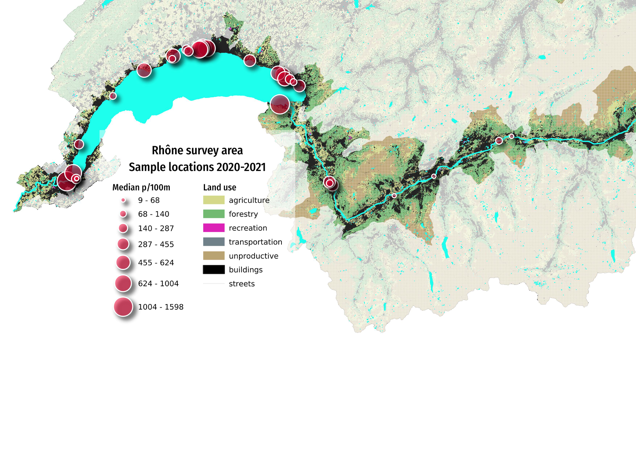

In [2]:
sut.display_image_ipython(bassin_map, thumb=(800,450))

## Sample locations and land use characteristics

In [3]:
# this is the data before the expanded foams and fragmented plastics are aggregated to Gfrags and Gfoams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")

# this is the aggregated survey data that is being used
# a_data is all the data in the survey period
a_data = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")
a_data["date"] = pd.to_datetime(a_data.date)

a_data.rename(columns={"% to agg":"% ag", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings"}, inplace=True)
luse_exp = ["% buildings", "% recreation", "% ag", "% woods", "streets km", "intersects"]

fd = sut.feature_data(a_data, this_feature["level"], these_features=[this_feature["slug"]])

# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    

# daily survey totals
dt_all = fd.groupby(["loc_date","location",this_level, "city","date"], as_index=False).agg(agg_pcs_quantity )

# the materials table
fd_mat_totals = sut.the_ratio_object_to_total(code_totals)

# summary statistics, nsamples, nmunicipalities, names of citys, population
t = sut.make_table_values(fd, col_nunique=["location", "loc_date", "city"], col_sum=["quantity"], col_median=[])

# make a map to the population values for each survey location/city
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city", "population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)

# update t with the population data
t.update(sut.make_table_values(fd_pop_map, col_nunique=["city"], col_sum=["population"], col_median=[]))

# update t with the list of locations from fd
t.update({"locations":fd.location.unique()})

# the lake and river names in the survey area
lakes = dfBeaches.loc[(dfBeaches.index.isin(t["locations"]))&(dfBeaches.water == "l")]["water_name"].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(t["locations"]))&(dfBeaches.water == "r")]["water_name"].unique()

# join the strings into comma separated list
obj_string = "{:,}".format(t["quantity"])
surv_string = "{:,}".format(t["loc_date"])
pop_string = "{:,}".format(int(t["population"]))

# make strings
date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, a total of {obj_string } objects were removed and identified over the course of {surv_string} surveys."
geo_context = F"The {bassin_label} results include {t['location']} different locations, {t['city']} different municipalities with a combined population of approximately {pop_string}."
# admin_context = F"There are {t['city']} different municipalities represented in these results with a combined population of approximately {pop_string}."
munis_joined = ", ".join(sorted(fd_pop_map["city"]))
lakes_joined = ", ".join(sorted(lakes))
rivers_joined = ", ".join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*{bassin_label} lakes:*\n\n>{lakes_joined}

*{bassin_label} rivers:*\n\n>{rivers_joined}

*{bassin_label} municipalities:*\n\n>{munis_joined}
"""
md(lake_string)


For the period between 2020-03 and 2021-05, a total of 28,454 objects were removed and identified over the course of 106 surveys. The Rhône survey area results include 32 different locations, 18 different municipalities with a combined population of approximately 488,138.

*Rhône survey area lakes:*

>Lac Léman

*Rhône survey area rivers:*

>Rhône

*Rhône survey area municipalities:*

>Allaman, Bourg-en-Lavaux, Genève, Gland, La Tour-de-Peilz, Lausanne, Lavey-Morcles, Leuk, Montreux, Préverenges, Riddes, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Sion, Tolochenaz, Versoix, Vevey


### Land use profile of the surveys

The land use is reported as the percent of total area attributed to each land use category within a 1500m radius of the survey location.  

Streets are reported as the total number of kilometers of streets within the 1500m radius. Intersects is also an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location. 

The ratio of the number of samples under varying land use profiles gives an indication of the environmental and economic conditions of the survey sites.

For more information [*Land use profile*](luseprofile)

*__Below:__ Distribution of land use characteristics.*

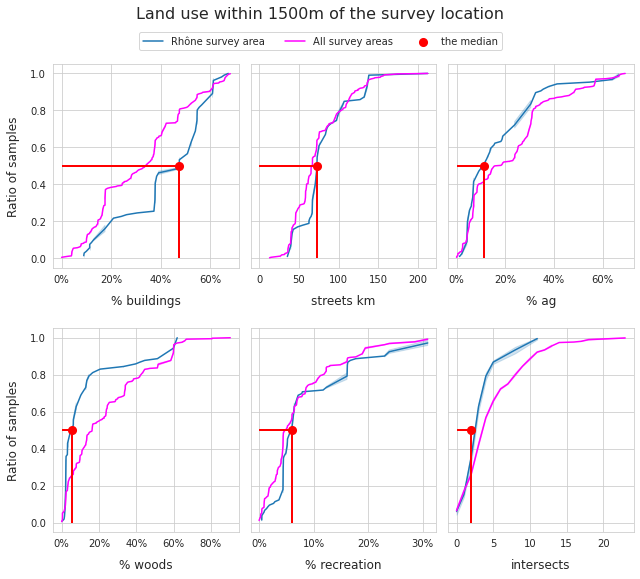

In [4]:
sns.set_style("whitegrid")
# the ratio of samples with respect to the different land use characteristics for each survey area
# the data to use is the unique combinations of loc_date and the land_use charcteristics of each location
project_profile = a_data[["loc_date", this_feature["level"], *luse_exp]].drop_duplicates()
dt_nw = fd[["loc_date", this_feature["level"], *luse_exp]].drop_duplicates()

# labels and levels
comps = [this_feature["slug"]]
comp_labels = {x:wname_wname.loc[x][0] for x in fd[this_level].unique()}

fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")

for i, n in enumerate(luse_exp):
    r = i%2
    c = i%3
    ax=axs[r,c]
    for element in[this_feature["slug"]]:
        data=dt_nw[dt_nw[this_feature["level"]] == element][n].values
        the_data = ECDF(data)
        
        # plot that
        sns.lineplot(x=the_data.x, y=the_data.y, ax=ax, label=bassin_label)
    
    # get the dist for all here
    a_all_surveys =  ECDF(project_profile[n].values)
    
    # plot that    
    sns.lineplot(x=a_all_surveys.x, y=a_all_surveys.y, ax=ax, label="All survey areas", color="magenta")
    
    # get the median from the data
    the_median = np.median(data)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=2)
    
    if i <= 3:
        if c == 0:            
            ax.set_ylabel("Ratio of samples", **ck.xlab_k)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass
      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_xlabel(n, **ck.xlab_k)
plt.tight_layout()
plt.subplots_adjust(top=.9, hspace=.3)
plt.suptitle("Land use within 1500m of the survey location", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.94), loc="center", ncol=3)    

plt.show()

### Cumulative totals by water feature

In [5]:
# aggregate the dimensional data
dims_parameters = dict(this_level=this_level, 
                       locations=fd.location.unique(), 
                       start_end=start_end, 
                       agg_dims=agg_dims)

dims_table = sut.gather_dimensional_data(dfDims, **dims_parameters)

# map the qauntity to the dimensional data
q_map = fd.groupby(this_level).quantity.sum()

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, "samples"] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, "quantity"] = q_map[name]

# add proper names for display
dims_table["water_feature"] = dims_table.index.map(lambda x: comp_labels[x])
dims_table.set_index("water_feature", inplace=True)
   
# get the sum of all survey areas
dims_table.loc[this_feature["name"]]= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={"samples":"samples","quantity":"items", "total_w":"total kg", "mac_plast_w":"plastic kg", "area":"m²", "length":"meters"}, inplace=True)

# format kilos and text strings
dims_table["plastic kg"] = dims_table["plastic kg"]/1000
dims_table[["m²", "meters", "samples", "items"]] = dims_table[["m²", "meters", "samples", "items"]].applymap(lambda x: "{:,}".format(int(x)))
dims_table[["plastic kg", "total kg"]] = dims_table[["plastic kg", "total kg"]].applymap(lambda x: "{:.2f}".format(x))

# figure caption
agg_caption = F"""
*__Below:__ The cumulative weights and measures for the {this_feature["name"]} and water bodies.*
"""
md(agg_caption)


*__Below:__ The cumulative weights and measures for the Rhône survey area and water bodies.*


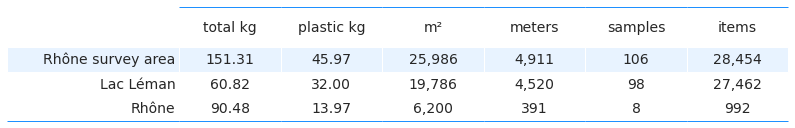

In [6]:
# make table
data = dims_table.reset_index()
colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*2,len(data)*.7))
sut.hide_spines_ticks_grids(ax)

table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")
table_one.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

### Distribution of survey results

In [7]:
# the surveys to chart
fd_dindex = dt_all.set_index("date")

# all the other surveys
ots = dict(level_to_exclude=this_feature["level"], components_to_exclude=fd[this_feature["level"]].unique())
dts_date = sut.the_other_surveys(a_data, **ots)
dts_date.head()

# the survey totals from all other survey areas
dts_date = dts_date.groupby(["loc_date","date"], as_index=False)[unit_label].sum()
dts_date.set_index("date", inplace=True)

# get the monthly or quarterly results for the feature
resample_plot, rate = sut.quarterly_or_monthly_values(fd_dindex , this_feature["name"], vals=unit_label, quarterly=["ticino"])

# scale the chart as needed to accomodate for extreme values
y_lim = 99
y_limit = np.percentile(dts_date[unit_label], y_lim)

# label for the chart that alerts to the scale
not_included = F"Values greater than {round(y_limit, 1)} not shown."

# figure caption
chart_notes = F"""
*__Left:__ {this_feature["name"]}, {start_date[:7]} through {end_date[:7]}, n={t["loc_date"]}. {not_included} __Right:__ {this_feature["name"]} empirical cumulative distribution of survey results.*
"""
md(chart_notes )


*__Left:__ Rhône survey area, 2020-03 through 2021-05, n=106. Values greater than 1360.7 not shown. __Right:__ Rhône survey area empirical cumulative distribution of survey results.*


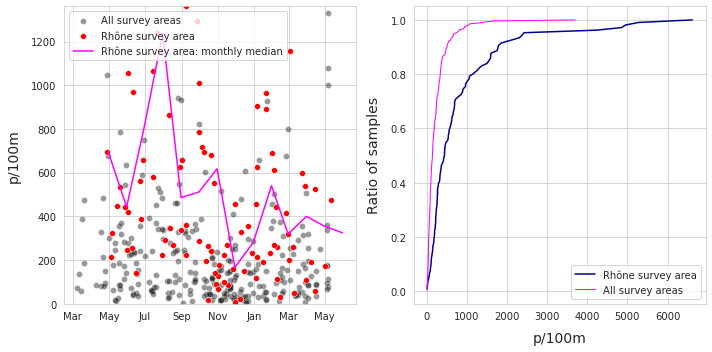

In [8]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(data=dts_date, x=dts_date.index, y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)
# all other surveys
sns.scatterplot(data=fd_dindex, x=fd_dindex.index, y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)

# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: {rate} median", color="magenta", ax=ax)

ax.set_ylim(0,y_limit )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = ECDF(dt_all[unit_label].values)    
sns.lineplot(x=feature_ecd.x, y=feature_ecd.y, color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = ECDF(dts_date[unit_label].values)
sns.lineplot(x=other_features.x, y=other_features.y, color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Ratio of samples", **ck.xlab_k14)

plt.tight_layout()
plt.show()

### Summary data and material types

In [9]:
# figure caption
summary_of_survey_totals = F"""
*__Left:__ {this_feature["name"]} summary of survey totals. __Right:__ {this_feature["name"]} material type and percent of total.*
"""
md(summary_of_survey_totals)


*__Left:__ Rhône survey area summary of survey totals. __Right:__ Rhône survey area material type and percent of total.*


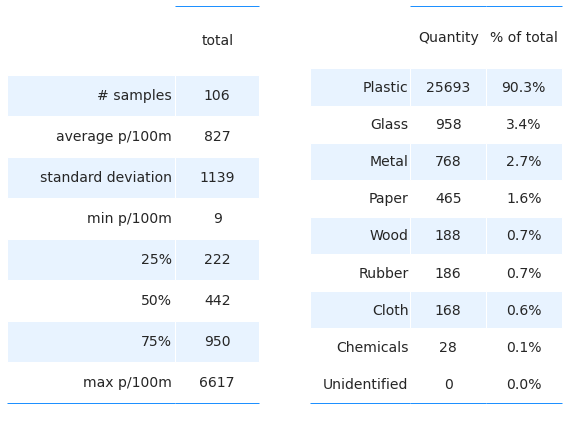

In [10]:
# get the basic statistics from pd.describe
cs = dt_all[unit_label].describe().round(2)

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)
fd_mat_totals = sut.make_string_format(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [this_feature["name"], "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(14)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")
table_three.set_fontsize(14)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## The most common objects

The most common objects are the **ten most abundant by quantity AND/OR objects identified in at least 50% of all surveys.** 

In [11]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] >= a_fail_rate].sort_values(by="quantity", ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# figure caption
rb_string = F"""
*__Below:__ {this_feature['name']} most common objects: fail rate >/= {a_fail_rate}%  and/or top ten by quantity. Combined, the most abundant objects represent {int(m_common_percent_of_total*100)}% of all objects found.*

Note : {unit_label} = median survey value.
"""
md(rb_string)
md(rb_string)


*__Below:__ Rhône survey area most common objects: fail rate >/= 50%  and/or top ten by quantity. Combined, the most abundant objects represent 79% of all objects found.*

Note : p/100m = median survey value.


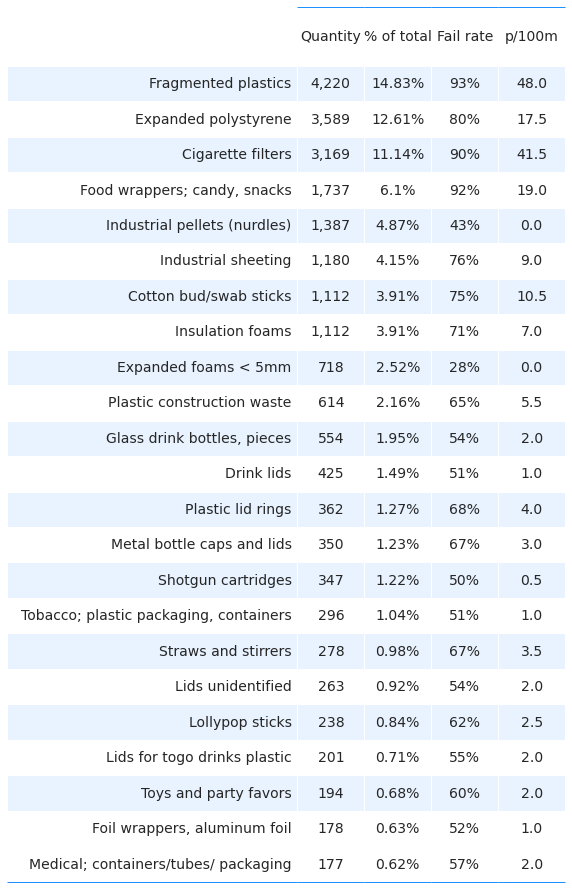

In [12]:
# format values for table
m_common["item"] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x: "{:,}".format(x))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{round(x,1)}")

cols_to_use = {"item":"Item","quantity":"Quantity", "% of total":"% of total", "fail rate":"Fail rate", unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

### Most common objects by water feature

In [13]:
rb_string = F"""
*__Below:__ {this_feature["name"]} most common objects: median {unit_label}*
"""
md(rb_string)


*__Below:__ Rhône survey area most common objects: median p/100m*


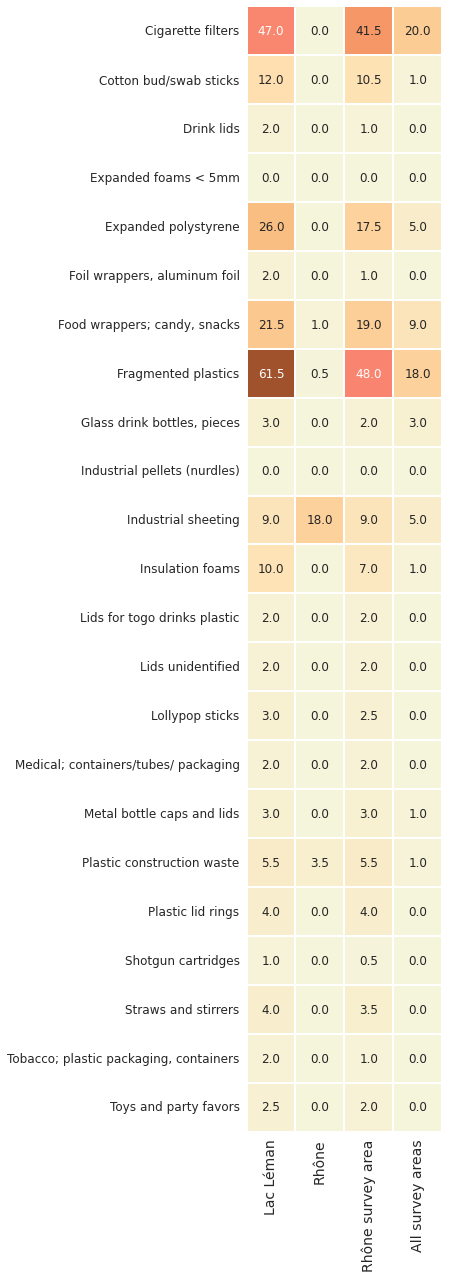

In [14]:
# aggregated survey totals for the most common codes for all the water features
m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, "loc_date","code"], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, "code"], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft["f_name"] = m_common_ft[this_level].map(lambda x: comp_labels[x])

# map the desctiption to the code
m_common_ft["item"] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[["item", unit_label, "f_name"]].pivot(columns="f_name", index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the survey area

c = sut.aggregate_to_group_name(fd[fd.code.isin(m_common.index)], column="code", name=this_feature["name"], val="med")

m_c_p[this_feature["name"]]= sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# the aggregated totals of all the data
c = sut.aggregate_to_group_name(a_data[(a_data.code.isin(m_common.index))], column="code", name=top, val="med")
m_c_p[top] = sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# chart that
fig, ax  = plt.subplots(figsize=(len(m_c_p.columns)*.9,len(m_c_p)*.9))
axone = ax

sns.heatmap(m_c_p, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")
axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="x")
axone.tick_params(labelsize=12, which="both", axis="y")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

### Most common objects monthly average

In [15]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*__Below:__ {this_feature["name"]}, monthly average survey result {unit_label}, with detail of the most common objects.*
"""
md(monthly_mc)


*__Below:__ Rhône survey area, monthly average survey result p/100m, with detail of the most common objects.*


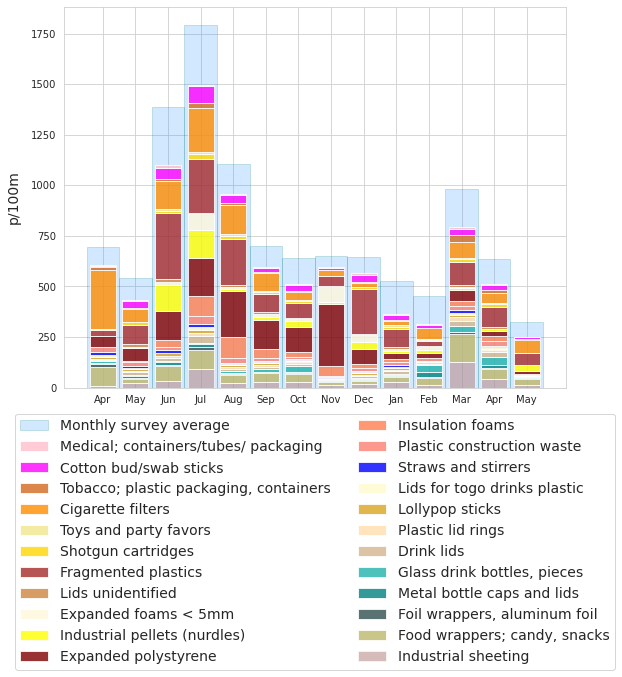

In [16]:
months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(9,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=a_color, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(.5, -.05), loc="upper center",  ncol=2, fontsize=14)       
plt.show()

## Survey results and land use

The land use mix is a unique representation of the type and amplitude of the economic activity and the environmental conditions around the survey location. The key indicators from the survey results are compared against the land use rates for a radius of 1500m from the survey location. 

An association is a relationship between the survey results and the land use profile that is unlikely due to chance. The magnitude of the relationship is neither defined nor linear. 

Ranked correlation is a non-parametric test to determine if there is a statistically significant relationship between land use and the objects identified in a litter survey. 

The method used is the Spearman’s rho or Spearmans ranked correlation coefficient. The test results are evaluated at p<0.05 for all valid lake samples in the survey area. 

1. Red/rose is a positive association
2. Yellow is a negative association
3. White means that p>0.05, there is no statistical basis to assume an association

In [17]:
corr_data = fd[(fd.code.isin(m_common.index))&(fd.water_name_slug.isin(lakes_of_interest))].copy()

alert_less_than_100 = len(corr_data.loc_date.unique()) <= 100

if alert_less_than_100:
    warning = F"""**There are less than 100 samples, proceed with caution. Beach litter surveys have alot of variance**"""
else:
    warning = ""

association = F"""*__Below:__ {this_feature["name"]} ranked correlation of the most common objects with respect to land use profile.
For all valid lake samples n={len(corr_data.loc_date.unique())}.*

*{warning}*
"""
md(association)

*__Below:__ Rhône survey area ranked correlation of the most common objects with respect to land use profile.
For all valid lake samples n=98.*

***There are less than 100 samples, proceed with caution. Beach litter surveys have alot of variance***


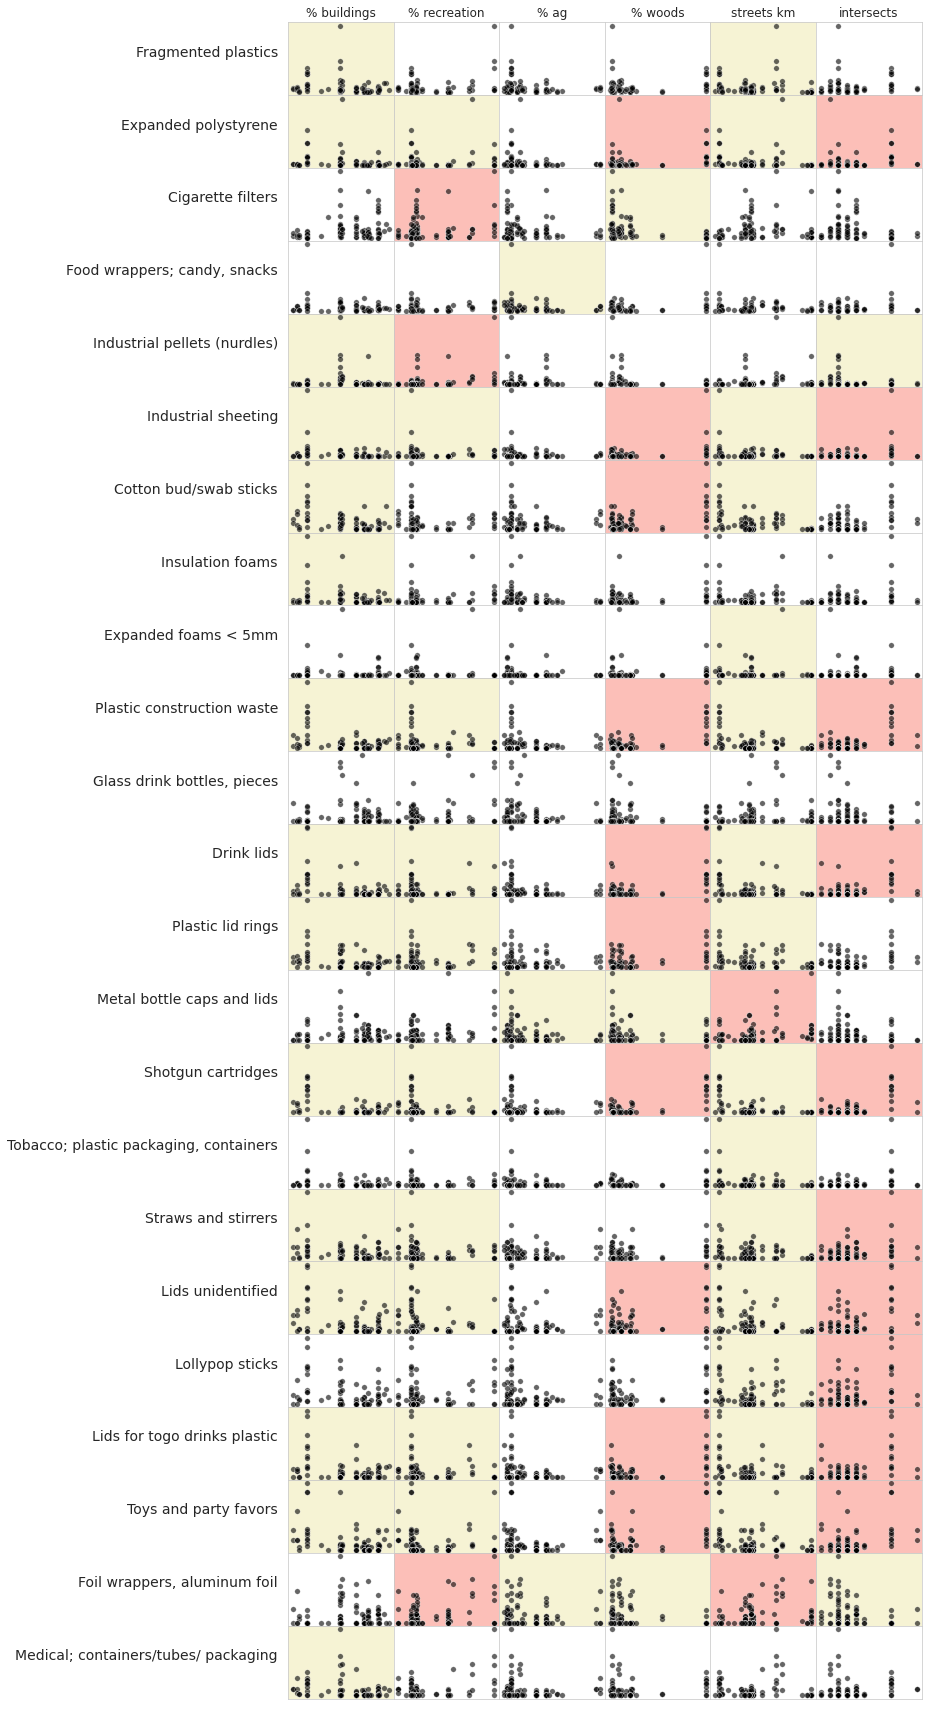

In [18]:
# chart the results of test for association
fig, axs = plt.subplots(len(m_common.index),len(luse_exp), figsize=(len(luse_exp)+7,len(m_common.index)+1), sharey="row")

# the test is conducted on the survey results for each code
for i,code in enumerate(m_common.index):
    # slice the data
    data = corr_data[corr_data.code == code]
    
    # run the test on for each land use feature
    for j, n in enumerate(luse_exp):       
        # assign ax and set some parameters
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis="both", which="both",bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
        
        # check the axis and set titles and labels       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha="right", **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        # run test
        _, corr, a_p = sut.make_plot_with_spearmans(data, ax, n)
        
        # if siginficant set adjust color to direction
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor("salmon")
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor("palegoldenrod")
                ax.patch.set_alpha(0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

*Key: &nbsp;if p>0.05 = white, &nbsp;if p < 0.05 and $\rho$ > 0 = red, &nbsp;if p < 0.05 and $\rho$ < 0 = yellow*

## Utility of the objects found

The utility type is based on the utilization of the object prior to it being discarded or object description if the original use is undetermined. Identified objects are classified into one of 260 predefined categories. The categories are grouped according to utilization or item description. 

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastics and pre-production plastic resins 
*  **infrastructure**: items related to construction and maintenance of buildings, roads and water/power supplies 
*  **food and drink**: all materials related to consuming food and drink
*  **agriculture**: primarily industrial sheeting i.e., mulch and row covers, greenhouses, soil fumigation, bale wraps. Includes hard plastics for agricultural fencing, flowerpots etc. 
*  **tobacco**: primarily cigarette filters, includes all smoking related material 
*  **recreation**: objects related to sports and leisure i.e., fishing, hunting, hiking etc.
*  **packaging non food and drink**: packaging material not identified as food, drink nor tobacco related 
*  **plastic fragments**: plastic pieces of undetermined origin or use 
*  **personal items**: accessories, hygiene and clothing related 

See the annex for the complete list of objects identified, includes descriptions and group classification. The section [Code groups](codegroups) describes each code group in detail and provides a comprehensive list of all objects in a group.

In [19]:
cg_poft = F"""
<br></br>
__Below:__ {this_feature["name"]} utility of objects found % of total by water feature. Fragmented objects with no clear identification remain classified by size.
"""
md(cg_poft)


<br></br>
__Below:__ Rhône survey area utility of objects found % of total by water feature. Fragmented objects with no clear identification remain classified by size.


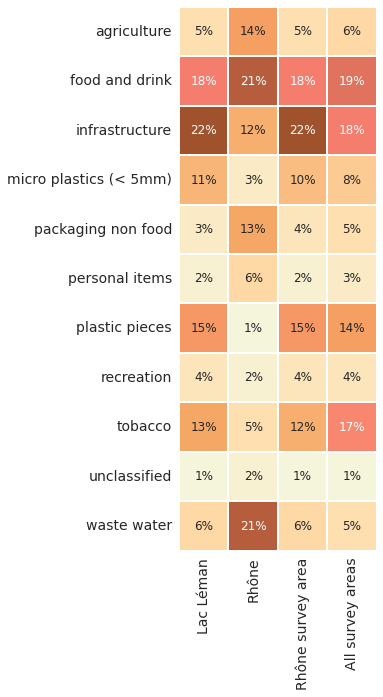

In [20]:
# code groups resluts aggregated by survey
groups = ["loc_date","groupname"]
cg_t = fd.groupby([this_level,*groups], as_index=False).agg(agg_pcs_quantity)

# the total per water feature
cg_tq = cg_t.groupby(this_level).quantity.sum()

# get the fail rates for each group per survey
cg_t["fail"]=False
cg_t["fail"] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each municipality
agg_this = {unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"} 
cg_t = cg_t.groupby([this_level, "groupname"], as_index=False).agg(agg_this)

# assign survey area total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, "f_total"] = cg_tq.loc[a_feature]

# get the percent of total for each group for each survey area
cg_t["pt"] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

# repeat for the survey area
data_table[bassin_label] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="pt")

# repeat for all the data
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="pt")

data = data_table
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.set_xlabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

In [21]:
cg_medpcm = F"""
<br></br>
*__Below:__ {this_feature["name"]} utility of objects found median {unit_label}. Fragmented objects with no clear identification remain classified by size.*
"""
md(cg_medpcm)


<br></br>
*__Below:__ Rhône survey area utility of objects found median p/100m. Fragmented objects with no clear identification remain classified by size.*


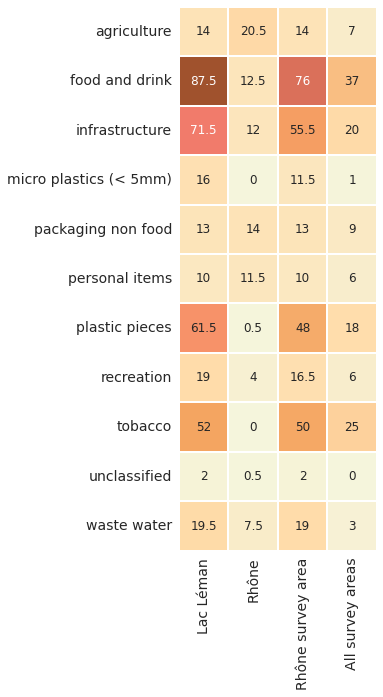

In [22]:
# median p/50m of all the water features
data_table = cg_t.pivot(columns="water_name_slug", index="groupname", values=unit_label)

# the survey area columns
data_table[bassin_label] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="med")

# column for all the surveys
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="med")

# merge with data_table
data = data_table
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Rivers 

In [23]:
rivers = fd[fd.w_t == "r"].copy()
r_smps = rivers.groupby(["loc_date", "date", "location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)
l_smps = fd[fd.w_t == "l"].groupby(["loc_date","date","location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)

chart_notes = F"""
*__Left:__ {this_feature["name"]} rivers, {start_date[:7]} through {end_date[:7]}, n={len(r_smps.loc_date.unique())}. {not_included} __Right:__ Summary data.*
"""
md(chart_notes )


*__Left:__ Rhône survey area rivers, 2020-03 through 2021-05, n=8. Values greater than 1360.7 not shown. __Right:__ Summary data.*


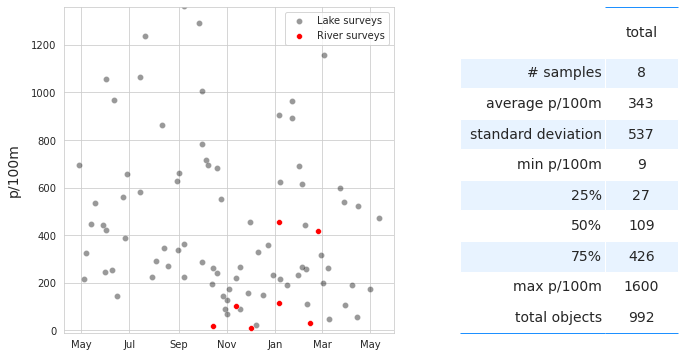

In [24]:
cs = r_smps[unit_label].describe().round(2)

# add project totals
cs["total objects"] = r_smps.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

# make the charts
fig = plt.figure(figsize=(11,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top}"

sns.scatterplot(data=l_smps, x="date", y=unit_label, color="black", alpha=0.4, label="Lake surveys", ax=ax)
sns.scatterplot(data=r_smps, x="date", y=unit_label, color="red", s=34, ec="white",label="River surveys", ax=ax)

ax.set_ylim(-10,y_limit )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

a_col = [this_feature["name"], "total"]

axone = fig.add_subplot(aspec[:, 7:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")
table_five.set_fontsize(14)

plt.show()

### Rivers most common objects

In [25]:
riv_mcommon = F"""
*__Below:__ {this_feature["name"]} rivers, most common objects {unit_label}: median survey value*
"""
md(riv_mcommon)


*__Below:__ Rhône survey area rivers, most common objects p/100m: median survey value*


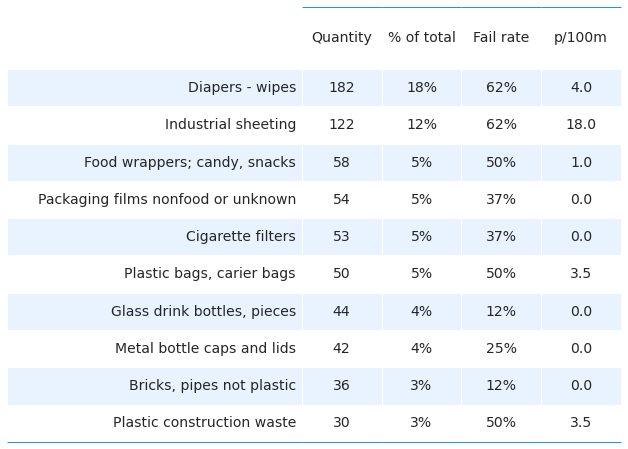

In [26]:
# the most common items rivers
r_codes = rivers.groupby("code").agg({"quantity":"sum", "fail":"sum", unit_label:"median"})
r_codes["Fail rate"] = (r_codes.fail/r_smps.loc_date.nunique()*100).astype("int")

# top ten
r_byq = r_codes.sort_values(by="quantity", ascending=False)[:10].index

# most common
r_byfail = r_codes[r_codes["Fail rate"] > 49.99].index
r_most_common = list(set(r_byq) | set(r_byfail))

# format for display
r_mc= r_codes.loc[r_most_common].copy()
r_mc["item"] = r_mc.index.map(lambda x: code_description_map.loc[x])
r_mc.sort_values(by="quantity", ascending=False, inplace=True)

r_mc["% of total"]=((r_mc.quantity/r_codes.quantity.sum())*100).astype("int")
r_mc["% of total"] = r_mc["% of total"].map(lambda x: F"{x}%")
r_mc["quantity"] = r_mc.quantity.map(lambda x: "{:,}".format(x))
r_mc["Fail rate"] = r_mc["Fail rate"].map(lambda x: F"{x}%")
r_mc["p/50m"] = r_mc[unit_label].map(lambda x: F"{np.ceil(x)}")
r_mc.rename(columns=cols_to_use, inplace=True)

data=r_mc[["Item","Quantity", "% of total", "Fail rate", unit_label]]

fig, axs = plt.subplots(figsize=(11,len(data)*.8))

sut.hide_spines_ticks_grids(axs)

table_six = sut.make_a_table(axs, data.values,  colLabels=list(data.columns), colWidths=[.48, .13,.13,.13, .13], **{"loc":"lower center"})
table_six.get_celld()[(0,0)].get_text().set_text(" ")
table_six.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

## Annex

### Fragmented foams and plastics by size

The table below contains the “Gfoam” and “Gfrags” components grouped for analysis. Objects labeled expanded foams are grouped as Gfoam and includes all expanded polystyrene foamed plastics > 0.5 cm.  Plastic pieces and objects made of combined plastic and foamed plastic materials > 0.5 cm. are grouped for analysis as Gfrags. 

In [27]:
frag_foams = F"""
*__Below:__ {this_feature["name"]} fragmented foams and plastics by size group.*
"""
md(frag_foams)


*__Below:__ Rhône survey area fragmented foams and plastics by size group.*


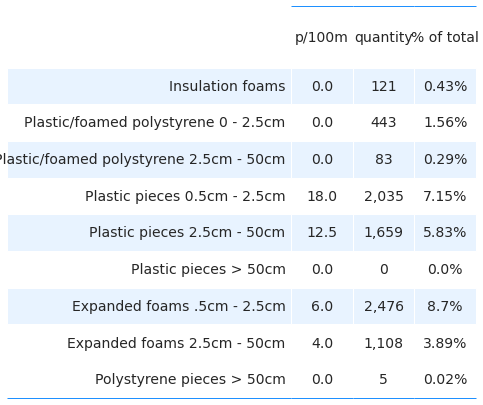

In [28]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ["G81", "G82", "G83", "G74"]

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(t["locations"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.8))

sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs,data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], a_color=a_color)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")
table_seven.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

### The survey locations

In [29]:
# display the survey locations
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[t["locations"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"slug":"location"}, inplace=True)
disp_beaches.set_index("location", inplace=True, drop=True)

disp_beaches

,latitude,longitude,city
location,,,
maladaire,46.446296,6.876960,La Tour-de-Peilz
preverenges,46.512690,6.527657,Préverenges
vidy-ruines,46.516221,6.596279,Lausanne
baby-plage-geneva,46.208558,6.162923,Genève
grand-clos,46.387746,6.843686,Saint-Gingolph
quai-maria-belgia,46.460156,6.836718,Vevey
anarchy-beach,46.447216,6.859612,La Tour-de-Peilz
lavey-les-bains-2,46.207726,7.011685,Lavey-Morcles
leuk-mattenstrasse,46.314754,7.622521,Leuk


### Inventory of items

In [30]:
pd.set_option("display.max_rows", None)
complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity", "% of total","fail rate"]]
complete_inventory.sort_values(by="quantity", ascending=False)

,item,groupname,quantity,% of total,fail rate
code,,,,,
Gfrags,Fragmented plastics,plastic pieces,4220,14.83,93
Gfoam,Expanded polystyrene,infrastructure,3589,12.61,80
G27,Cigarette filters,tobacco,3169,11.14,90
G30,"Food wrappers; candy, snacks",food and drink,1737,6.10,92
G112,Industrial pellets (nurdles),micro plastics (< 5mm),1387,4.87,43
G67,Industrial sheeting,agriculture,1180,4.15,76
G74,Insulation foams,infrastructure,1112,3.91,71
G95,Cotton bud/swab sticks,waste water,1112,3.91,75
G117,Expanded foams < 5mm,micro plastics (< 5mm),718,2.52,28
